# ASFE21 Part 2: Failure Probability Based Approach

In [1]:
from os import path
from typing import Callable, Union

import matplotlib.pyplot as plt
# Dependencies
import numpy as np
import pandas as pd
from IPython.display import display, HTML
from scipy import stats
from scipy.interpolate import interp1d

from sfeprapy.mcs2 import MCS2, EXAMPLE_INPUT_DF

plt.style.use('seaborn-white')

In [2]:
# Helper function: return a function f(fractile) = teq
def make_func_cdf2teq(teq: np.ndarray) -> Callable:
    hist, edges = np.histogram(teq, bins=np.arange(0, max(361, max(teq[teq < np.inf]) + 0.5), 0.5))
    teq, fractile = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    return interp1d(fractile, teq, bounds_error=False)


# Helper function: return a function f(teq) = fractile
def make_func_teq2cdf(teq: np.ndarray) -> Callable:
    hist, edges = np.histogram(teq, bins=np.arange(0, max(361, max(teq[teq < np.inf]) + 0.5), 0.5))
    teq, fractile = (edges[:-1] + edges[1:]) / 2, np.cumsum(hist / np.sum(hist))
    return interp1d(teq, fractile, bounds_error=False)


def func_A2cdf(
        A: np.ndarray,
        beta: np.ndarray,
        p_1: float, p_2: float, p_3: float, p_4: float,
):
    """Calculate time equivalence CDF for a given building total floor area and betas.
    
    Solve:
                             P_f_fi = P_a_fi
    p_1 * A * p_2 * p_3 * p_4 * p_5 = P_a_fi(H)
                                p_5 = P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
                        1 - teq_cdf = P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
                            teq_cdf = 1 - P_a_fi(H) / (p_1 * A * p_2 * p_3 * p_4)
    """
    # solve/interpolate teq cdf
    P_a_fi = stats.norm(loc=0, scale=1).cdf(-beta)
    teq_cdf = 1 - np.divide(P_a_fi, p_1 * A * p_2 * p_3 * p_4, dtype=np.float64)
    return teq_cdf


In [3]:
def plot_contour_text_p_i(ax, title, p_i, x=0.95, y=0.97, va='top', ha='right', bbox_pad=-0.01, bbox_fc=(1, 1, 1, 0.5)):
    ax.text(
        x, y,
        f'{title}\n'
        f'$p_1$={p_i["p_1"]}\n'
        f'$p_2$={p_i["p_2"]}\n'
        f'$p_3$={p_i["p_3"]}\n'
        f'$p_4$={p_i["p_4"]}',
        transform=ax.transAxes, ha=ha, va=va, ma='left', fontsize='x-small',
        bbox=dict(boxstyle=f'square,pad={bbox_pad}', fc=bbox_fc, ec='none')
    )


def plot_contour(
        ax, xx, yy, zz,
        xlabel: str, xticks=None, xticks_minor=None, xticklabels=None, xlim=None,
        levels=None, clabel_fmt=lambda x: f'{x:.0f}', clabel_manual=False,
        cmap: str = 'Greys',
):
    cs = ax.contour(xx, yy, zz, levels=levels, linewidths=0.5, colors='k', linestyles='dotted', antialiased=True)
    cf = ax.contourf(xx, yy, zz, levels=levels, cmap=cmap, alpha=0.6, extend='both')
    ax.clabel(
        cs, cs.levels, inline=True, fmt=clabel_fmt, fontsize='x-small',
        use_clabeltext=True, inline_spacing=5, manual=clabel_manual
    )
    format_ax(
        ax=ax, xlabel=xlabel, xticks=xticks, xticklabels=xticklabels, xlim=xlim, ticklabel_format_style='sci',
        legend_visible=False
    )
    if xticks_minor is not None: ax.set_xticks(xticks_minor, minor=True)

    return cf


def ax_annotate(
        ax, text, xy, xytext, fontsize='x-small', ha='center', va='bottom', ma='left',
        arrowprops_style='->', arrowprops_lw=.5, arrowprops_lc='k',
        bbox_pad=-0.01, bbox_fc=(1, 1, 1, 0.5), bbox_ec='none'
):
    ax.annotate(
        text, xy=xy, xytext=xytext,
        fontsize=fontsize, ha=ha, va=va, ma=ma,
        arrowprops=dict(arrowstyle=arrowprops_style, lw=arrowprops_lw),
        bbox=dict(boxstyle=f'square,pad={bbox_pad}', fc=bbox_fc, ec=bbox_ec)
    )


# Helper function: print DataFrame in HTML format
def print_df(df: pd.DataFrame):
    display(HTML(df.to_html()))


def savefig(fig, fname, dname='fig', dpi=300, bbox_inches='tight', pad_inches=0.02, *_, **__):
    plt.tight_layout()
    plt.show()
    try:
        fig.savefig(path.join(dname, fname), dpi=dpi, bbox_inches=bbox_inches, pad_inches=pad_inches, *_, **__)
    except:
        print('figure not saved')

        
# Helper function: standard figure format
def format_ax(
        ax,
        xlabel: str = None, ylabel: str = None, legend_title: str = None,
        xlabel_fontsize='small', ylabel_fontsize='small',
        xscale=None, yscale=None,
        xticks=None, yticks=None,
        xticks_minor=None, yticks_minor=None,
        xticklabels=None, yticklabels=None,
        ticks_labelsize='x-small',
        xlim=None, ylim=None,
        ticklabel_format_style=None, ticklabel_format_axis='y', ticklabel_format_scilimits=(0, 0),
        legend_loc: int = 0, legend_ncol=1, legend_fontsize='x-small', legend_title_fontsize='x-small',
        legend_visible: bool = True,
        grid_which='both', grid_ls='--'
):
    if xlabel is not None: ax.set_xlabel(xlabel, fontsize=xlabel_fontsize)
    if ylabel is not None: ax.set_ylabel(ylabel, fontsize=ylabel_fontsize)
    if xscale is not None: ax.set_xscale(xscale)
    if yscale is not None: ax.set_yscale(yscale)
    if xticks is not None: ax.set_xticks(xticks)
    if yticks is not None: ax.set_yticks(yticks)
    if xticks_minor is not None: ax.set_xticks(xticks_minor, minor=True)
    if yticks_minor is not None: ax.set_yticks(yticks_minor, minor=True)
    if xticklabels is not None: ax.set_xticklabels(xticklabels)
    if yticklabels is not None: ax.set_yticklabels(yticklabels)
    if xlim is not None: ax.set_xlim(xlim)
    if ylim is not None: ax.set_ylim(ylim)
    if legend_visible is True:
        ax.legend(
            title=legend_title, loc=legend_loc, ncol=legend_ncol, frameon=True, fontsize=legend_fontsize,
            title_fontsize=legend_title_fontsize
        ).set_visible(legend_visible)
    ax.grid(which=grid_which, ls=grid_ls)
    ax.tick_params(labelsize=ticks_labelsize)

    if ticklabel_format_style is not None:
        ax.ticklabel_format(
            style=ticklabel_format_style,
            scilimits=ticklabel_format_scilimits,
            axis=ticklabel_format_axis,
            useMathText=True
        )

    if ticklabel_format_style is not None:
        ax.yaxis.offsetText.set_fontsize('x-small')

## Allowable failure probability

In [4]:
# Define correlation between building height and beta values
storey = [4, 10, 15]
height = [i*3.333 for i in storey]
beta =   [3.7, 4.2, 4.4]
func_H2beta = interp1d(height, beta, bounds_error=False, fill_value=(beta[0], beta[-1]))

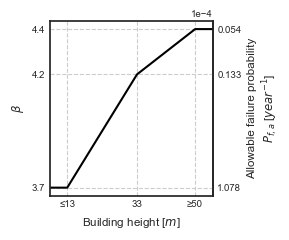

In [5]:
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=100)
ax.plot(np.linspace(0, 100, 1000), func_H2beta(np.linspace(0, 100, 1000)), c='k')
format_ax(
    ax=ax, xlabel='Building height [$m$]', ylabel=r'$\beta$', 
    xticks=height, xticklabels=[f'≤{height[0]:.0f}']+[f'{i:.0f}' for i in height[1:-1]]+[f'≥{height[-1]:.0f}'], xlim=(min(height)-5, max(height)+5), 
    yticks=beta,
    legend_visible=False
)

n = stats.norm(loc=0, scale=1)
ax_yaxis2 = ax.secondary_yaxis('right', functions=(lambda x: n.cdf(-x), lambda x: -n.ppf(x)))
ax_yaxis2.set_yticks([n.cdf(-i) for i in beta])
ax_yaxis2.ticklabel_format(style='sci', scilimits=(0, 0))
ax_yaxis2.set_ylabel('Allowable failure probability\n$P_{f,a}$ [${year}^{-1}$]', fontsize='small')
ax_yaxis2.tick_params(labelsize='x-small')
ax_yaxis2.yaxis.offsetText.set_fontsize('x-small')

savefig(fig, 'beta_vs_H.png')

## Structural failure probability
### Prepare MCS inputs

In [6]:
# Update inputs to include travelling fire model and other parameters
df_inputs_2 = EXAMPLE_INPUT_DF.copy()
df_inputs_2.loc['n_simulations'] = 10_000  # set to simulation iteration to 100k to make fine plots later
df_inputs_2.loc['solver_thickness_ubound'] = 0.045

print_df(df_inputs_2)

,Residential,Office,Retail
case_name,,,
n_simulations,10000,10000,10000
fire_time_step,10,10,10
fire_time_duration,18000,18000,18000
fire_hrr_density:dist,uniform_,uniform_,uniform_
fire_hrr_density:lbound,0.32,0.15,0.27
fire_hrr_density:ubound,0.57,0.65,1.0
fire_load_density:dist,gumbel_r_,gumbel_r_,gumbel_r_
fire_load_density:lbound,10,10,10.0
fire_load_density:ubound,1200,1200,2000.0


### Run MCS

In [7]:
# Run MCS
cases_to_run=['Residential', 'Office', 'Retail']
mcs = MCS2(print_stats=False)
mcs.inputs = df_inputs_2
mcs.n_threads = 4
mcs.run_mcs(cases_to_run=cases_to_run)

CASE                    : Residential
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:06<00:00, 1639.42it/s]


CASE                    : Office
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 10000


100%|███████████████| 10000/10000 [00:05<00:00, 1967.22it/s]


CASE                    : Retail
NO. OF THREADS          : 4
NO. OF SIMULATIONS      : 10000


 91%|██████████████▌ | 9091/10000 [00:05<00:00, 1794.86it/s]


KeyboardInterrupt: 

### Time equivalence results

In [ ]:
# Inspect simulation results
mcs_out = mcs.mcs_out
dict_teq = {case: mcs_out.loc[mcs_out['case_name'] == case]["solver_time_equivalence_solved"] / 60.0 for case in cases_to_run}
dict_teq = {k: v[~np.isnan(v)] for k, v in dict_teq.items()}  # remove np.nan values, non convergency iterations

dict_func_teq2cdf = {k: make_func_teq2cdf(teq=v) for k, v in dict_teq.items()}
dict_func_cdf2teq = {k: make_func_cdf2teq(teq=v) for k, v in dict_teq.items()}

fig, ax = plt.subplots(figsize=(2.5,2.5), dpi=100)
lss=['-', '-.', 'dotted']
FRs = np.linspace(0, 180, 100)
for i, case in enumerate(cases_to_run):
    ax.plot(FRs, dict_func_teq2cdf[case](FRs), label=case, ls=lss[i], c='k')
format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', ylabel='CDF', xlim=(30, 180), ylim=(0, 1), xticks=np.arange(30, 181, 15,), yticks=np.arange(0, 1.1, 0.1))

savefig(fig, 'teq_2.png')

### Comparing against Kirby et al

In [ ]:
kirby_teq = [  # order matters!
    [[60, 75, 90, 105, 120], [0.361, 0.629, 0.844, 0.953, 0.991]],  # Residential
    [[30, 60, 90, 120], [0.464, 0.800, 0.928, 0.982]],  # Office
    [[30, 60, 90, 120], [0.404, 0.734, 0.912, 0.968]],  # Retail
]

# Compare against Kirby
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.1*3, 2.5), sharex=True, sharey=True, dpi=100)

for i, case in enumerate(cases_to_run):
    ax = axes[i]
    ax.scatter(kirby_teq[i][0], kirby_teq[i][1], label='Kirby et al', marker='o', facecolors='none', edgecolors='k')
    ax.scatter(kirby_teq[i][0], dict_func_teq2cdf[case](kirby_teq[i][0]), label='SFEPRAPY', marker='^', facecolors='none', edgecolors='k')
    format_ax(ax=ax, xlabel='Equivalent of time exposure [$min$]', xticks=np.arange(30, 121, 30), xticks_minor=np.arange(30, 121, 15), ylim=(0, 1), yticks=np.arange(0, 1.1, 0.1), legend_title=case, legend_loc=4, legend_fontsize='xx-small', legend_title_fontsize='xx-small')
axes[0].set_ylabel('CDF', fontsize='small')

savefig(fig, 'benchmark_2.png')

### Failure probabilies

In [ ]:
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

In [ ]:
def P_f_fi_func(p_1: float, p_2: float, p_3: float, p_4: float, A: np.ndarray, teq: np.ndarray) -> pd.DataFrame:
    P_f_fi_ = dict(FR = np.arange(30, 181, 1))
    p_5 = 1 - make_func_teq2cdf(teq=teq)(P_f_fi_['FR'])
    for i in A:
        P_f_fi_[f'{i/1e3:.0f}k m²'] = p_1 * i * p_2 * p_3 * p_4 * p_5
    return pd.DataFrame.from_dict(P_f_fi_).set_index('FR')

As = [1000, 2000, 4000, 8000, 16000, 32000]
dict_dfs = dict()
for occupancy, p_i  in dict_p_i.items():
    dict_dfs[occupancy] = P_f_fi_func(A=As, teq=dict_teq[occupancy], **p_i)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(2.3*3, 2.5), sharex=True, sharey=True, dpi=100)
lss = ['-', (0, (5, 1)), '--', '-.', (0, (3, 1, 1, 1)), ':', (0, (5, 10))]
for i, key in enumerate(dict_dfs.keys()):
    ax = axes[i]
    df = dict_dfs[key]
    x = df.index.values
    ys = df.to_dict(orient='list')
    for j, key_ in enumerate(ys):
        y = ys[key_]
        ax.plot(x, y, label=key_, ls=lss[j], c='k')
    format_ax(
        ax=ax, xlabel='Equivalent of time exposure [$min$]',
        xlim=(30, 180), xticks=np.arange(30, 181, 15),
        yscale='log', 
        legend_title=key, legend_ncol=1, legend_loc=3
    )

ax = axes[0]
ax.set_ylabel(r'$P_{f,fi}$ [${year}^{-1}$]', fontsize='small')

savefig(fig, 'P_f_fi_vs_A.png')

## Recommended fire resistance periods
### Buildings without sprinklers

In [ ]:
# define correlation between height and total floor area
# resi, 10 flats per storey, each flat is 80 sq.m
# office/retail, 1200 sq.m per storey
dict_H_per_storey = dict(Residential=2.4, Office=3.4, Retail=4)
dict_A_per_storey = dict(Residential=800, Office=1200, Retail=1200)
def func_A_vs_H(occupancy: str, height: Union[float, int, np.ndarray]):
    return height / dict_H_per_storey[occupancy] * dict_A_per_storey[occupancy]

In [ ]:
# define p parameters
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=1),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=1),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=1),
}

# calculate time equivalence
height, area = np.meshgrid(np.linspace(18, 50, 30), np.linspace(1000, 100000, 30))
teqs_no_sprinklers = dict()
for case, ps in dict_p_i.items():
    teq_cdf = func_A2cdf(A=area, beta=func_H2beta(height), **ps)
    teq = dict_func_cdf2teq[case](teq_cdf)
    teq[teq_cdf<0] = 0  # for instances where P_a_fi / (p_1 * A * p_2 * p_3 * p_4) is greater than 1, set it to 1, i.e., CDF teq = 0
    teqs_no_sprinklers[case] = teq

# visualisation, logscale
teqs = teqs_no_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.5), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    Hs = np.linspace(np.amin(height), np.amax(height), 50)
    As = func_A_vs_H(occupancy=key, height=Hs)
    levels = np.arange(60, 181, 15) if key == 'Residential' else np.arange(45, 181, 15)
    ax = axes[i]
    if key == 'Retail':
        plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='left', va='bottom', x=0.01, y=0.45, bbox_pad=0.4, bbox_fc=(0,0,0,0))
    else:
        plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='left', va='bottom', x=0.01, y=0.01, bbox_pad=0.4, bbox_fc=(0,0,0,0))
    cf = plot_contour(
        ax=ax, xx=height, yy=area, zz=teqs[key], xlabel = 'Building height [$m$]', levels=levels,
        xticks=[18, 30, 40, 50], 
        xticks_minor=np.arange(20, 50, 2.5),
        xticklabels=['≤18', 30, 40, '≥50'],
    )
    # add line text
    ax.plot(Hs, As, c='k', lw=.5, ls='--')
    xy=(42, func_A_vs_H(key, 42))
    ax_annotate(ax, text=f'$H_i$: {dict_H_per_storey[key]} $m$\n$A_i$: {dict_A_per_storey[key]} $m^2$', xy=xy, xytext=(xy[0], xy[1]+0.6e4), bbox_fc=(0,0,0,0), va='bottom')

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='small')
axes[0].set_yscale('log')

savefig(fig, 'contour_1_logscale.png')

### Buildings with sprinklers

In [ ]:
# define p parameters
dict_p_i = {
    "Residential": dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=0.09),
    "Office": dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
    "Retail": dict(p_1=4.0e-7, p_2=0.2, p_3=0.25, p_4=0.07),
}

# calculate time equivalence
height, area = np.meshgrid(np.linspace(18, 50, 20), np.linspace(1000, 100000, 20))
teqs_with_sprinklers = dict()
for case, ps in dict_p_i.items():
    teq_cdf = func_A2cdf(A=area, beta=func_H2beta(height), **ps)
    teq = dict_func_cdf2teq[case](teq_cdf)
    teq[teq_cdf<0] = 0  # for instances where P_a_fi / (p_1 * A * p_2 * p_3 * p_4) is greater than 1, set it to 1, i.e., CDF teq = 0
    teqs_with_sprinklers[case] = teq

# visualisation, logscale
teqs = teqs_with_sprinklers
fig, axes = plt.subplots(figsize=(2.2*3, 2.5), nrows=1, ncols=3, dpi=100, sharex=True, sharey=True)
for i, key in enumerate(teqs):
    Hs = np.linspace(np.amin(height), np.amax(height), 50)
    As = func_A_vs_H(occupancy=key, height=Hs)
    levels = np.arange(60, 181, 15) if key == 'Residential' else np.arange(45, 181, 15)
    ax = axes[i]
    plot_contour_text_p_i(ax=ax, title=key, p_i=dict_p_i[key], ha='left', va='bottom', x=0.01, y=0.01, bbox_pad=0.4, bbox_fc=(0,0,0,0))
    cf = plot_contour(
        ax=ax, xx=height, yy=area, zz=teqs[key], xlabel = 'Building height [$m$]', levels=levels,
        xticks=[18, 30, 40, 50], 
        xticks_minor=np.arange(20, 50, 2.5),
        xticklabels=['≤18', 30, 40, '≥50'],
    )
    # add line text
    ax.plot(Hs, As, c='k', lw=.5, ls='--')
    xy=(35, func_A_vs_H(key, 35))
    ax_annotate(ax, text=f'$H_i$: {dict_H_per_storey[key]} $m$\n$A_i$: {dict_A_per_storey[key]} $m^2$', xy=xy, xytext=(xy[0], xy[1]-0.6e4), va='top', bbox_fc=(0,0,0,0))

axes[0].set_ylabel('Total floor area [$m^2$]', fontsize='small')
axes[0].set_yscale('log')

savefig(fig, 'contour_2_logscale.png')

### Comparing against BS 9999:2017

In [ ]:
# A helper function to determine the required fire resistance periods
def get_fr(height, occupancy, sprinkler:bool, dict_func_cdf2teq, beta):
    
    # work out p_i
    p_i = dict()
    if occupancy == 'Residential': p_i=dict(p_1=6.5e-7, p_2=0.2, p_3=0.0625, p_4=.09)
    if occupancy == 'Office': p_i=dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=.07)
    if occupancy == 'Retail': p_i=dict(p_1=3.0e-7, p_2=0.2, p_3=0.25, p_4=.07)
    if sprinkler is False:
        p_i['p_4'] = 1.0
    
    # work out total floor area
    A = func_A_vs_H(occupancy=occupancy, height=height)
    
    # work out teq
    teq_cdf = func_A2cdf(A=A, beta=beta, **p_i)
    teq = dict_func_cdf2teq[occupancy](teq_cdf)
    teq[teq_cdf<0] = 0  # for instances where P_a_fi / (p_1 * A * p_2 * p_3 * p_4) is greater than 1, set it to 1, i.e., CDF teq = 0
    teqs_with_sprinklers[case] = teq

    return teq

In [ ]:
print(f'{"Method":<10} {"Occupancy":<15} {"Sprinkler":<10} {"18 m  30 m  60 m  100 m":<}')
H_ = np.array([18, 30, 60, 100])

for method in ['SFEPRAPY']:
    for occupancy in ['Residential', 'Office', 'Retail']:
        for sprinkler in [False, True]:
            frs = get_fr(H_, occupancy, sprinkler, dict_func_cdf2teq, func_H2beta(H_))
            frs[frs==0] = 60 if occupancy == 'Residential' else 45
            frs = np.ceil(frs/15)*15
            frs = [f'{k:<5.0f}' for k in frs]
            print(f'{str(method):10} {occupancy:<15} {str(sprinkler):<10} {" ".join(frs):<}')